「達人データサイエンティストによる理論と実践　Python 機械学習プログラミング」10章より

# データの読み込み

In [1]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

boston = load_boston()

boston_df = pd.DataFrame(boston.data, columns = boston.feature_names) 
boston_df['MEDV'] = boston.target

boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


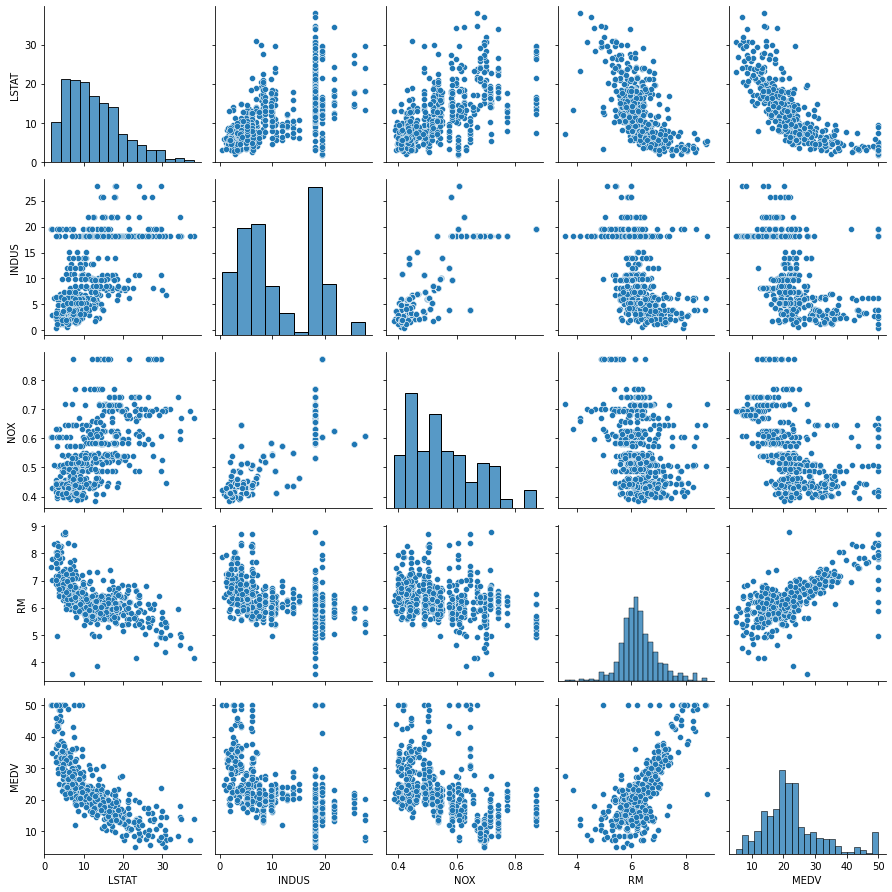

In [2]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(boston_df[cols], size=2.5)
plt.tight_layout()
plt.show()

# ヒートマップ作製

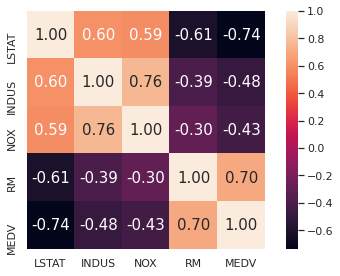

In [5]:
cm = np.corrcoef(boston_df[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

plt.tight_layout()
plt.show()

# 回帰モデルの実装

ADALINEの実装（勾配降下法）

*   コスト関数：誤差平方和
*   前処理：正規化

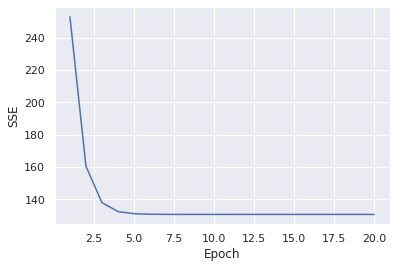

In [53]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            # print(self.w_)
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

X = boston_df[['RM']].values
y = boston_df[['MEDV']].values

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y).flatten()

lr = LinearRegressionGD()
lr.fit(X_std, y_std)

plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

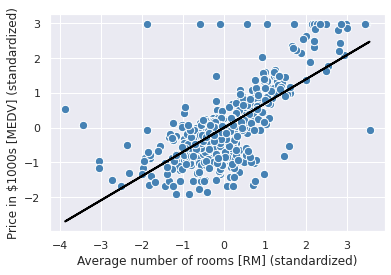

In [52]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()


# scikit-learnを使った回帰モデル

Slope: 9.102
Intercept: -34.671


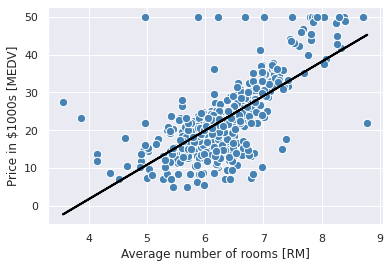

In [54]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')

plt.show()

# RANSACを使ったロバスト回帰



*   ランダムな数のサンプルからモデルを学習させる。
*   許容範囲の誤差にある他のデータを選択し、再び学習させることを繰り返す。
*   外れ値を避けて学習が可能。





Slope: 11.026
Intercept: -46.621


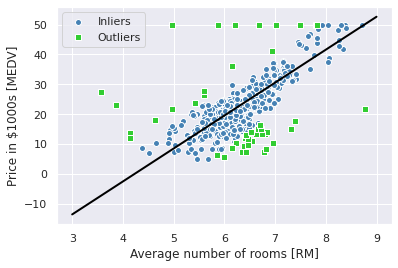

In [62]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_loss', 
                         residual_threshold=10.0, 
                         random_state=0)


ransac.fit(X, y)
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

# 重回帰モデルと性能評価

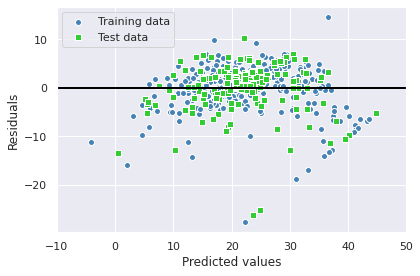

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


In [65]:
from sklearn.model_selection import train_test_split
X = boston_df.iloc[:, :-1].values
y = boston_df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 非線形回帰

[[1.00000e+00 2.58000e+02 6.65640e+04]
 [1.00000e+00 2.70000e+02 7.29000e+04]
 [1.00000e+00 2.94000e+02 8.64360e+04]
 [1.00000e+00 3.20000e+02 1.02400e+05]
 [1.00000e+00 3.42000e+02 1.16964e+05]
 [1.00000e+00 3.68000e+02 1.35424e+05]
 [1.00000e+00 3.96000e+02 1.56816e+05]
 [1.00000e+00 4.46000e+02 1.98916e+05]
 [1.00000e+00 4.80000e+02 2.30400e+05]
 [1.00000e+00 5.86000e+02 3.43396e+05]]


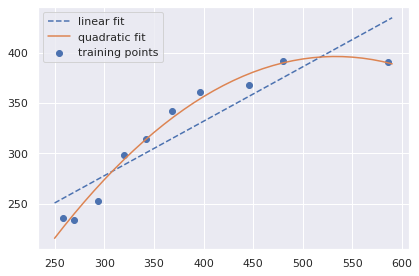

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


In [68]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)
print(X_quad)

# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/10_10.png', dpi=300)
plt.show()

y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

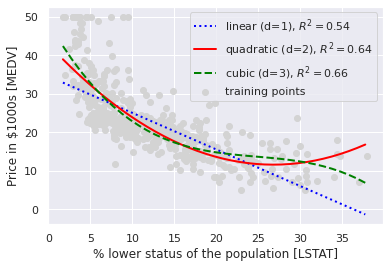

In [69]:
X = boston_df[['LSTAT']].values
y = boston_df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')

plt.show()